In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import normaltest

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

Així doncs ara podreu respondre a les següents preguntes:

1. Quin és el tipus de cada atribut? 
3. Quin és l'atribut objectiu? Per què?

In [2]:
df = pd.read_csv('follow.csv')
idx = df.sample(700).index
df.drop(columns=['profile_id'], inplace=True)

train_df = df[df.index.isin(idx)]
test_df = df[~df.index.isin(idx)]


target = train_df['motor_speed']
train_df = train_df[['motor_speed', 'u_q', 'u_d', 'i_d', 'i_q', 'pm', 'ambient', 'torque', 'coolant', 'stator_winding', 'stator_tooth',
          'stator_yoke']]

print(df.columns)

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque'],
      dtype='object')


In [3]:
print(f"shape:\n{train_df.shape}")
print(f"Types:\n{train_df.dtypes}")
print(f"\nNulls:\n{train_df.isnull().sum()}")

shape:
(700, 12)
Types:
motor_speed       float64
u_q               float64
u_d               float64
i_d               float64
i_q               float64
pm                float64
ambient           float64
torque            float64
coolant           float64
stator_winding    float64
stator_tooth      float64
stator_yoke       float64
dtype: object

Nulls:
motor_speed       0
u_q               0
u_d               0
i_d               0
i_q               0
pm                0
ambient           0
torque            0
coolant           0
stator_winding    0
stator_tooth      0
stator_yoke       0
dtype: int64


In [4]:
train_df.describe().T

# i_x son corrientes
# u_x son voltajes
# pm temperatura del motor de iman 
# ambient temperatura exterior
# torque fuerza del motor (Nm)
# coolant es temperatura del refrigerante
# stator_x temperatura de los diferentes estatores

,count,mean,std,min,25%,50%,75%,max
motor_speed,700.0,2308.807421,1838.322338,-0.005986,500.023633,1999.986235,3940.540366,5999.950684
u_q,700.0,58.057147,44.648221,-2.732425,18.262018,50.031078,95.782993,132.011795
u_d,700.0,-28.670426,61.059457,-131.413940,-79.173287,-9.044715,0.823280,130.682330
i_d,700.0,-68.588278,65.131967,-239.006119,-109.084998,-50.727955,-3.520433,-0.000258
i_q,700.0,40.918970,85.922436,-265.744552,1.096335,22.683497,99.263644,301.706055
pm,700.0,58.592909,18.998307,21.411684,43.623375,60.005655,72.131505,111.564880
ambient,700.0,24.552114,1.934764,18.986956,23.193718,24.807380,26.185366,29.028939
torque,700.0,33.786411,71.941911,-221.926213,-0.014778,19.580534,85.239679,259.195221
coolant,700.0,36.421071,21.913202,15.321778,18.708151,26.993833,49.935537,93.430100
stator_winding,700.0,66.258387,28.528013,19.246748,43.549038,65.481408,86.898436,133.080002


In [5]:
# Dummies de categoricas
columns = train_df.columns
for col in columns:
    if df[col].dtype == 'object':
        print(col)
        train_df = pd.concat([train_df, pd.get_dummies(train_df[col],prefix=col)], axis=1)
        
pd.get_dummies(pd.Series(list('acba')))

,a,b,c
0,1,0,0
1,0,0,1
2,0,1,0
3,1,0,0


In [6]:
# Gestionar nans
columns = train_df.columns
max_nans = .4 * train_df.shape[0]
strategy = 'zeros'
for col in columns:
    nans = train_df[col].isnull().sum()
    if nans > 0:
        if nans >= max_nans:
            train_df.drop(columns=col, inplace=True)
        else:
            if strategy == 'zeros':
                train_df.loc[train_df[col].isnull(), col] = 0
            if strategy == 'mean':
                train_df.loc[train_df[col].isnull(), col] = train_df.loc[~train_df[col].isnull(). col].mean()
            if strategy == 'mean_noise':
                pass



2. Quins atributs tenen una distribució Guassiana?

2308.8074213124532
58.057146876000395
-28.67042616691604
u_d is not a normal distribution
-68.58827798962973
40.91896988791449
58.59290858895771
24.552113524140164
33.78641085632992
36.42107075813878
66.25838699388287
56.9525127297576
48.2292604387273


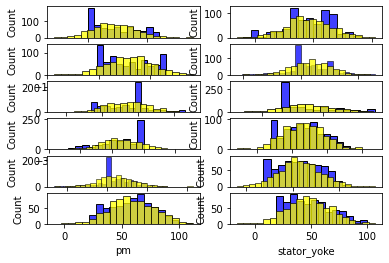

In [7]:
fig, axes = plt.subplots(6,2)
for idx, col in enumerate(train_df.columns):
    sns.histplot(train_df[col],ax=axes[idx % 6, 0 if idx < 6 else 1],label=col,color='blue')
    sns.histplot(np.random.normal(train_df[col].mean(), train_df[col].std(), size=700),ax=axes[idx % 6, 0 if idx < 6 else 1],color='yellow')
    print(train_df[col].mean())
    stat, p = normaltest(train_df[col])
    if p > .05:
        print(f"{col} is not a normal distribution")
plt.show()

mean: 4.0824486648359327e-16, std: 0.9999999999999999
mean: -5.43295567264782e-16, std: 0.9999999999999992
mean: 5.15460690004537e-17, std: 1.0000000000000007
u_d is not a normal distribution
mean: -1.1165671561944431e-15, std: 1.0
mean: -4.777924088118978e-16, std: 1.0000000000000002
mean: 1.6577215790545908e-15, std: 1.0000000000000004
mean: 3.2577115608286735e-15, std: 1.0000000000000002
mean: 1.7755638229540895e-16, std: 1.0
mean: -1.965094753586527e-16, std: 0.9999999999999992
mean: -7.803281830222529e-16, std: 0.9999999999999998
mean: -1.3861927478891241e-16, std: 1.0000000000000007
mean: -8.77393396032338e-16, std: 0.9999999999999999


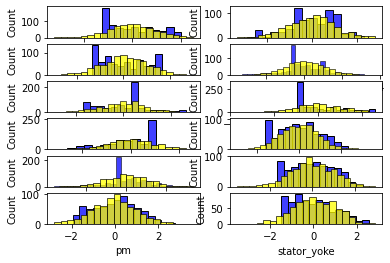

In [8]:
norm_train_df = (train_df - train_df.mean()) / train_df.std()
fig, axes = plt.subplots(6,2)
for idx, col in enumerate(norm_train_df.columns):
    sns.histplot(norm_train_df[col],ax=axes[idx % 6, 0 if idx < 6 else 1],label=col,color='blue')
    sns.histplot(np.random.normal(norm_train_df[col].mean(), norm_train_df[col].std(), size=700),ax=axes[idx % 6, 0 if idx < 6 else 1],color='yellow')
    print(f"mean: {norm_train_df[col].mean()}, std: {norm_train_df[col].std()}")
    stat, p = normaltest(norm_train_df[col])
    if p > .05:
        print(f"{col} is not a normal distribution")
plt.show()

In [9]:
norm_train_df = norm_train_df.drop(columns=['u_d'])
train_df = train_df.drop(columns=['u_d'])
test_df = test_df.drop(columns=['u_d'])
norm_test_df = (test_df - test_df.mean()) / test_df.std()

1. Quin són els atributs més importants per fer una bona predicció?

3. Quina correlació hi ha entre els atributs de la vostra base de dades?


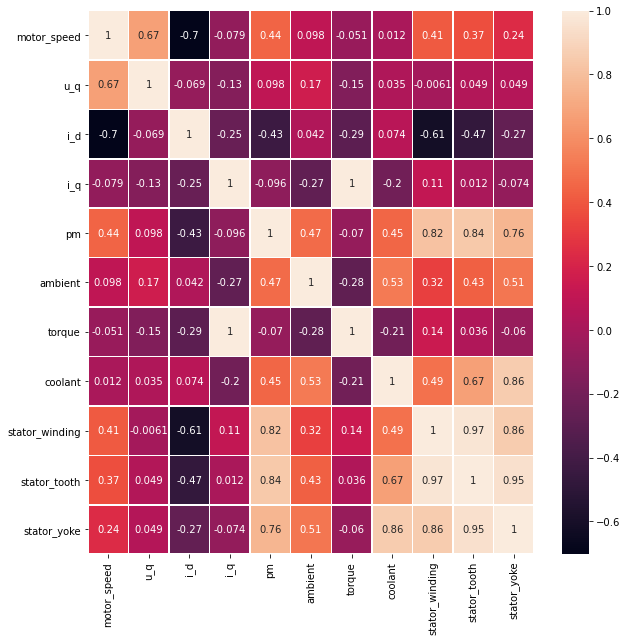

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(norm_train_df.corr(method='pearson'), annot=True, linewidth=0.5)
plt.show()

In [11]:
# Mirar operaciones entre atributos



2. Amb quin atribut s'assoleix un MSE menor?

4. Com influeix la normalització en la regressió?

u_q - MSE: 1867847.015; R2: 0.463
i_d - MSE: 1782202.138; R2: 0.488
i_q - MSE: 3468088.953; R2: 0.003
pm - MSE: 2733773.202; R2: 0.214
ambient - MSE: 3440487.104; R2: 0.011
torque - MSE: 3479036.316; R2: -0.000
coolant - MSE: 3487517.722; R2: -0.003
stator_winding - MSE: 2850804.251; R2: 0.180
stator_tooth - MSE: 2944239.827; R2: 0.154
stator_yoke - MSE: 3269642.059; R2: 0.060


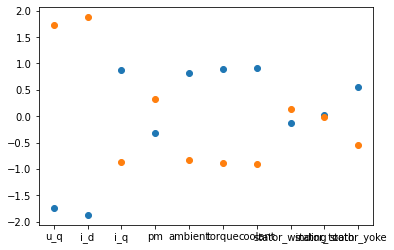

In [12]:
linear_model = LinearRegression()

features = train_df.columns
train_y = train_df['motor_speed'].values
test_y = test_df['motor_speed'].values

mses, r2s = [], []
features = features.tolist()
features.remove('motor_speed')
for feature in features:
    if feature == 'motor_speed':
        pass
    else:
        linear_model.fit(train_df[[feature]].values, train_y)
        preds = linear_model.predict(test_df[[feature]].values)
        mse = mean_squared_error(test_y, preds)
        mses.append(mse)
        r2 = r2_score(test_y, preds)
        r2s.append(r2)

        print(f"{feature} - MSE: {mse:.3f}; R2: {r2:.3f}")

mses = np.array(mses)
mses = (mses - mses.mean()) / mses.std()
r2s = np.array(r2s)
r2s = (r2s - r2s.mean()) / r2s.std()
plt.scatter(features, mses)
plt.scatter(features, r2s)
plt.show()

In [13]:
linear_model = LinearRegression()

features = norm_train_df.columns
norm_train_y = norm_train_df['motor_speed'].values
norm_test_y = norm_test_df['motor_speed'].values

for feature in features:
    if feature == 'motor_speed':
        pass
    else:
        linear_model.fit(norm_train_df[[feature]].values, norm_train_y)
        preds = linear_model.predict(norm_test_df[[feature]].values)
        
        print(f"{feature} - MSE: {mean_squared_error(norm_test_y, preds):.3f}; R2: {r2_score(norm_test_y, preds):.3f}")

u_q - MSE: 0.536; R2: 0.464
i_d - MSE: 0.508; R2: 0.492
i_q - MSE: 0.994; R2: 0.006
pm - MSE: 0.783; R2: 0.217
ambient - MSE: 0.986; R2: 0.014
torque - MSE: 0.997; R2: 0.003
coolant - MSE: 1.000; R2: 0.000
stator_winding - MSE: 0.816; R2: 0.183
stator_tooth - MSE: 0.843; R2: 0.156
stator_yoke - MSE: 0.937; R2: 0.063


5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?

6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?


PCA_1 - MSE: 0.833; R2: 0.167
PCA_2 - MSE: 0.816; R2: 0.184
PCA_3 - MSE: 0.141; R2: 0.859
PCA_4 - MSE: 0.129; R2: 0.871
PCA_5 - MSE: 0.130; R2: 0.870
PCA_6 - MSE: 0.121; R2: 0.879
PCA_7 - MSE: 0.087; R2: 0.913
PCA_8 - MSE: 0.087; R2: 0.913
PCA_9 - MSE: 0.085; R2: 0.915
PCA_10 - MSE: 0.072; R2: 0.928


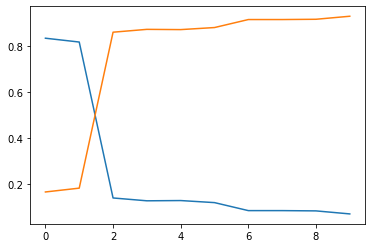

In [14]:
mses, r2s = [], []
for i in range(1, 11):
    pca = PCA(i)
    x_train = pca.fit_transform(norm_train_df[['u_q', 'i_d', 'i_q', 'pm', 'ambient', 'torque', 'coolant', 'stator_winding', 'stator_tooth',
              'stator_yoke']].values)
    x_test = pca.transform(norm_test_df[['u_q', 'i_d', 'i_q', 'pm', 'ambient', 'torque', 'coolant', 'stator_winding', 'stator_tooth',
              'stator_yoke']].values)

    linear_model = LinearRegression()
    linear_model.fit(x_train, norm_train_y)
    preds = linear_model.predict(x_test)

    mse = mean_squared_error(norm_test_y, preds)
    r2 = r2_score(norm_test_y, preds)
    print(f"PCA_{i} - MSE: {mse:.3f}; R2: {r2:.3f}")
    
    mses.append(mse)
    r2s.append(r2)
    
plt.plot(mses)
plt.plot(r2s)
plt.show()


Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 

2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 

<img src="mse_follow.png">
<img src="gradient_descent_follow.png">
<img src="gradient_descent_more_follow.png">


In [15]:
class LinealRegressionGradDescent:
    def __init__(self, num_params, lr=.1, max_iter=1000, tolerance=1e-3):
        self.w = np.zeros((num_params+1, 1))
        self.lr = lr
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.cost_list = []
        
    def predict(self, x):
        return np.dot(x,  self.w)
    
    def inference(self, x):
        x = np.hstack((np.ones((x.shape[0], 1)), x)) # añadimos un 1 a todas las muestras
        return self.predict(x)
    
    def compute_cost(self, x, y):
        samples = x.shape[0]
        preds = self.predict(x)
        
        error = preds - y
        cost = 1/(2 * samples) * np.dot(error.T, error)   #  (1/2m)*sum[(error)^2]
        
        return cost, error
    
    def update(self, x, error):
        samples = x.shape[0]
        self.w = self.w - (self.lr * (1/samples) * np.dot(x.T, error))
    
        
    def fit(self, x, y):
        x = np.hstack((np.ones((x.shape[0], 1)), x)) # añadimos un 1 a todas las muestras
        old_cost = 1e9
        cost, _ = self.compute_cost(x,y)
        i = 0
        
        while i < self.max_iter and (old_cost - cost) > self.tolerance:
            i += 1
            cost, error = self.compute_cost(x, y)
            self.update(x, error)
            
            self.cost_list.append(cost)
            

            
#lreg_gd = LinealRegressionGradDescent(10)
#lreg_gd.fit(norm_train_df[['u_q', 'i_d', 'i_q', 'pm', 'ambient', 'torque', 'coolant', 'stator_winding', 'stator_tooth', 'stator_yoke']].values, norm_train_y.reshape(-1, 1))
# print(len(lreg_gd.cost_list), lreg_gd.cost_list[0],lreg_gd.cost_list[-1])
#preds = lreg_gd.inference(norm_test_df[['u_q', 'i_d', 'i_q', 'pm', 'ambient', 'torque', 'coolant', 'stator_winding', 'stator_tooth','stator_yoke']].values)
lreg_gd = LinealRegressionGradDescent(1)
lreg_gd.fit(norm_train_df[['i_d']].values, norm_train_y.reshape(-1, 1))
print(len(lreg_gd.cost_list), lreg_gd.cost_list[0],lreg_gd.cost_list[-1])
preds = lreg_gd.inference(norm_test_df[['i_d']].values)

mse = mean_squared_error(norm_test_y, preds)
r2 = r2_score(norm_test_y, preds)
print(mse, r2)    

1000 [[0.49928571]] [[0.25294587]]
0.5081442637548012 0.49180109120124293
